In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader, Dataset, random_split
import numpy as np
from matplotlib import pyplot
import pandas as pd
import matplotlib.pyplot as plt

from torchvision import datasets, transforms

from torch.utils.tensorboard import SummaryWriter

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("device is", device)

2024-04-23 11:58:22.832575: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


device is cuda:0


In [2]:
class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.act = nn.Sigmoid()

        # input: 100      
        self.fc1 = nn.Linear(in_features=100, out_features=128)    
        self.fc2 = nn.Linear(in_features=128, out_features=784)

        self.sig = nn.Sigmoid()


    
    def forward(self, x, num):
        x = self.fc1(x) #100->128
        x = self.act(x) #128->128
        x = self.fc2(x) #128->784
        x = self.sig(x) #784->784 (28x28)
        return x

class Generator_loss(nn.Module):
    def __init__(self):
        super(Generator_loss, self).__init__()

    def forward(self, output_fake):
        loss = -torch.log(output_fake)
        return loss.mean()
    
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.act = nn.ReLU()

        # input: 784     
        self.fc1 = nn.Linear(in_features=784, out_features=128) 
        self.fc2 = nn.Linear(in_features=128, out_features=1)

        self.sig = nn.Sigmoid()

    def forward(self, x, num):
        x = self.fc1(x) #784->128
        x = self.act(x) #128->128
        x = self.fc2(x) #128->1
        x = self.sig(x) #1->1
        return x
    
class Discriminator_loss(nn.Module):
    def __init__(self):
        super(Discriminator_loss, self).__init__()

    def forward(self, output_real, output_fake):
        loss = -(torch.log(output_real)+torch.log(1-output_fake))
        return loss.mean()

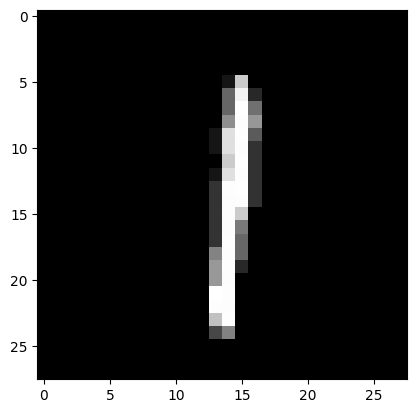

In [3]:
# Define the mini-batch size
batch_size = 100

# Download the dataset and create the dataloaders
mnist_train = datasets.MNIST("./", train=True, download=True, transform=transforms.ToTensor())
mnist_test = datasets.MNIST("./", train=False, download=True, transform=transforms.ToTensor())

# Dataset is split 8:2
train_size = int(0.8 * len(mnist_train))
val_size = len(mnist_train) - train_size
mnist_train, mnist_val = random_split(mnist_train, [train_size, val_size])

train_loader = torch.utils.data.DataLoader(mnist_train, batch_size=batch_size, shuffle=False)
test_loader = torch.utils.data.DataLoader(mnist_test, batch_size=batch_size, shuffle=False)
val_loader = torch.utils.data.DataLoader(mnist_val, batch_size=batch_size, shuffle=False)

to_onehot = nn.Embedding(10, 10)
to_onehot.weight.data = torch.eye(10)

def plot_digit(data):
    data = data.view(28, 28)
    plt.imshow(data, cmap="gray")

    plt.show()

images, labels = next(iter(train_loader))
plot_digit(images[0])

In [ ]:
def train_models(model_d, criterion_d, optimizer_d, scheduler_d, model_g, criterion_g, optimizer_g, scheduler_g, epochs, train_loader, k, batch_sz):
    it = iter(train_loader)
    for epoch in range(epochs):
          
        #Train Discriminator 
        for batch_nr in range(k):
            try:
                images,_ = next(it)
            except:
                it = iter(train_loader)
                images,_ = next(it)          
            out_real = model_d(torch.flatten(images,start_dim=1).to(device))
            out_fake = model_d(model_g(torch.rand(batch_sz,1,100).to(device)))
            optimizer_d.zero_grad()
            loss_d = criterion_d(out_real,out_fake).to(device)
            loss_d.backward()
            optimizer_d.step()
            scheduler_d.step()

        #Train Generator
        out_fake = model_d(model_g(torch.rand(batch_sz,1,100).to(device)))
        optimizer_g.zero_grad()
        loss_g = criterion_g(out_fake).to(device)
        loss_g.backward()
        optimizer_g.step()
        scheduler_g.step()
        
        disp = model_g(torch.rand(batch_sz,1,100).to(device))
        
        if epoch%50==0:
            print("Epoch:",epoch)  
            print("loss_g:",loss_g.item(),"\tloss_d:",loss_d.item())
        if epoch%500==0:
            plot_digit(torch.reshape(disp[0,0,:],(28,28)).detach().cpu())

In [ ]:
lr = 0.01
k = 5
epochs = 250000

generator = Generator().to(device)
disciminator = Discriminator().to(device)

optimizer_gen = torch.optim.SGD(generator.parameters(), lr=lr)
optimizer_dis = torch.optim.SGD(disciminator.parameters(), lr=lr)

criterion_gen = Generator_loss()
criterion_dis = Discriminator_loss()

scheduler_gen = torch.optim.lr_scheduler.StepLR(optimizer_gen, step_size=25, gamma=0.998)
scheduler_dis = torch.optim.lr_scheduler.StepLR(optimizer_dis, step_size=25, gamma=0.998)

train_models(disciminator, criterion_dis, optimizer_dis, scheduler_dis, generator, criterion_gen, optimizer_gen, scheduler_gen, epochs, train_loader, k, batch_size)